<a href="https://colab.research.google.com/github/cemredogan-ceng/BUSI/blob/main/busi_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.8314 - loss: 0.3942 - val_accuracy: 0.9106 - val_loss: 0.2931
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9214 - loss: 0.2677 - val_accuracy: 0.9106 - val_loss: 0.3337
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9250 - loss: 0.2582 - val_accuracy: 0.9106 - val_loss: 0.2470
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9248 - loss: 0.2261 - val_accuracy: 0.9106 - val_loss: 0.2399
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9168 - loss: 0.2203 - val_accuracy: 0.9106 - val_loss: 0.2352
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9195 - loss: 0.2110 - val_accuracy: 0.9134 - val_loss: 0.2198
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9217 - loss: 0.2044 - val_accuracy: 0.9123 - val_loss: 0.2190
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9214 - loss: 0.2002 - val_accuracy: 0.9143 -

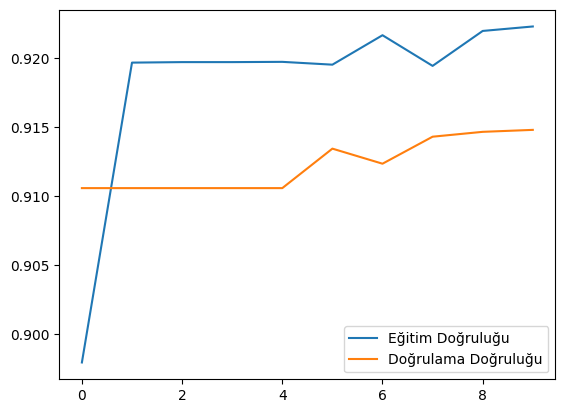

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


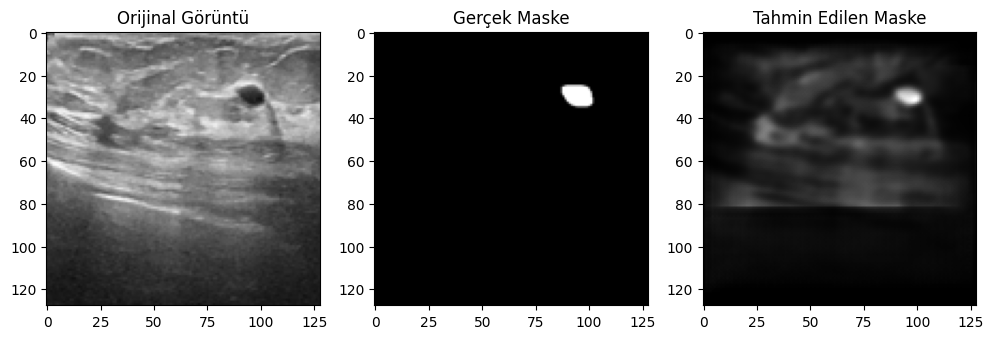

In [50]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

# Veri seti yolunu belirtin
dataset_path = "/content/drive/MyDrive/Dataset_BUSI_with_GT"  # Google Drive'daki yolunuzu ekleyin

# Orijinal görüntüleri ve maskeleri saklamak için listeler
images = []  # Orijinal görüntüleri tutacak liste
masks = []   # Maskeleri tutacak liste

# Sınıflar
classes = ['normal', 'malignant', 'benign']

# Veri setini yükleme
for label in classes:
    folder_path = os.path.join(dataset_path, label)
    for file in os.listdir(folder_path):
        if file.endswith('.png') and '_mask' not in file:  # Orijinal görüntüleri seçiyoruz
            # Orijinal görüntüyü yükle
            img_path = os.path.join(folder_path, file)
            img = Image.open(img_path).resize((128, 128))  # Görüntüyü yeniden boyutlandır
            images.append(np.array(img) / 255.0)  # Normalize et

            # Maskeyi yükle
            mask_path = os.path.join(folder_path, file.replace('.png', '_mask.png'))
            mask = Image.open(mask_path).convert("L").resize((128, 128))  # Grayscale ve boyutlandırma
            masks.append(np.array(mask) / 255.0)  # Normalize et

# Numpy dizilerine dönüştürme
images = np.array(images)  # Görseller (128x128x3)
masks = np.expand_dims(np.array(masks), axis=-1)  # Maskeler (128x128x1)

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)


# U-Net Modeli
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


# Modeli oluştur ve derle
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modeli eğit
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=16
)

# Eğitim sürecini görselleştirme
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.legend()
plt.show()

# Test verisi üzerinde tahmin
sample_img = X_test[0]
sample_mask = y_test[0]
predicted_mask = model.predict(np.expand_dims(sample_img, axis=0))[0]

# Görüntüleme
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Orijinal Görüntü")
plt.imshow(sample_img)
plt.subplot(1, 3, 2)
plt.title("Gerçek Maske")
plt.imshow(sample_mask.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Tahmin Edilen Maske")
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.show()


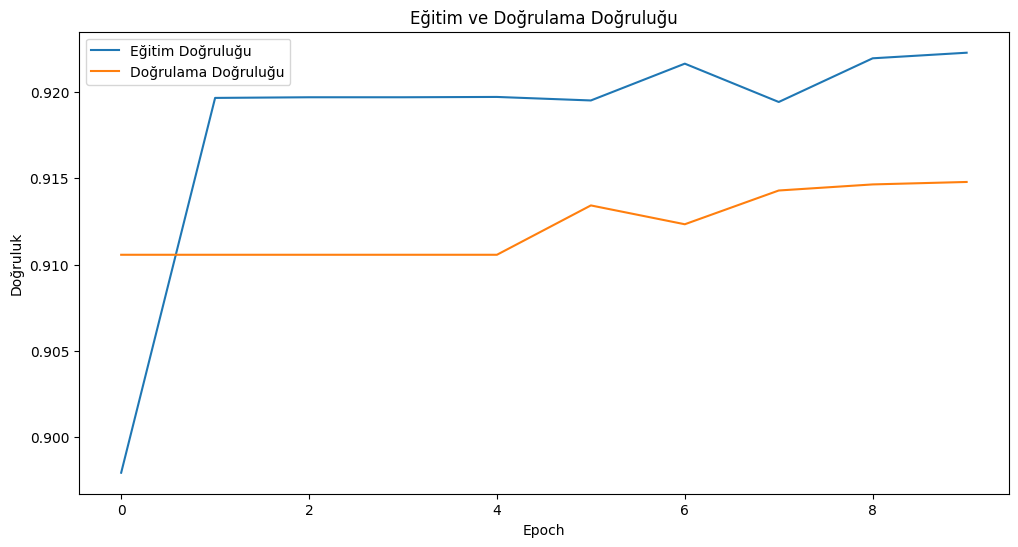

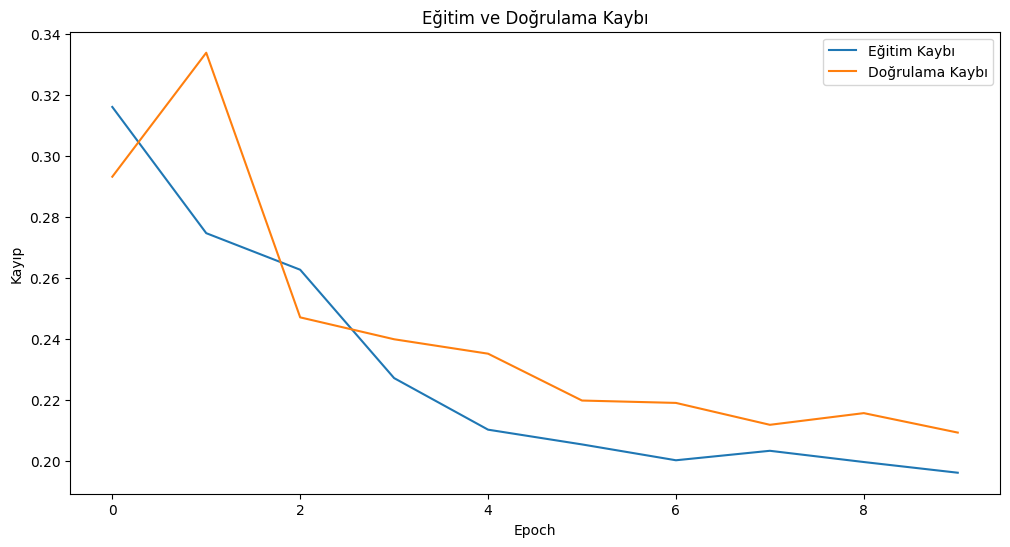

In [51]:
# Eğitim ve doğrulama doğruluğu
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.legend()
plt.show()

# Eğitim ve doğrulama kaybı
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


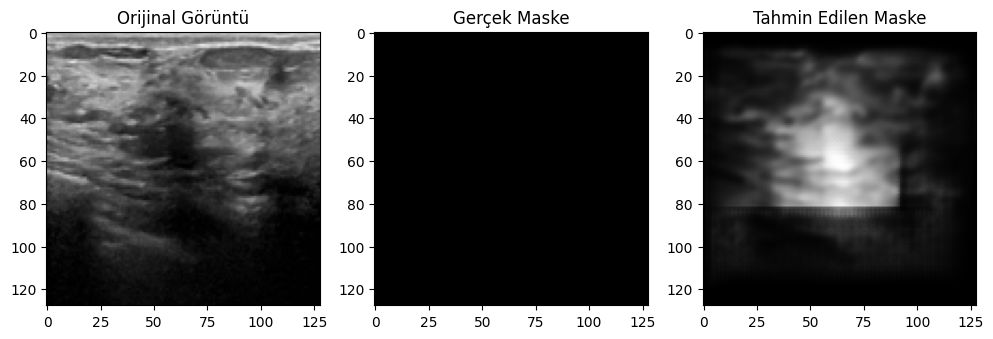

In [52]:
# Test setinden rastgele bir örnek seçelim
random_index = np.random.randint(0, len(X_test))
sample_img = X_test[random_index]
sample_mask = y_test[random_index]
predicted_mask = model.predict(np.expand_dims(sample_img, axis=0))[0]

# Görüntüleme
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Orijinal Görüntü")
plt.imshow(sample_img)

plt.subplot(1, 3, 2)
plt.title("Gerçek Maske")
plt.imshow(sample_mask.squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Tahmin Edilen Maske")
plt.imshow(predicted_mask.squeeze(), cmap='gray')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


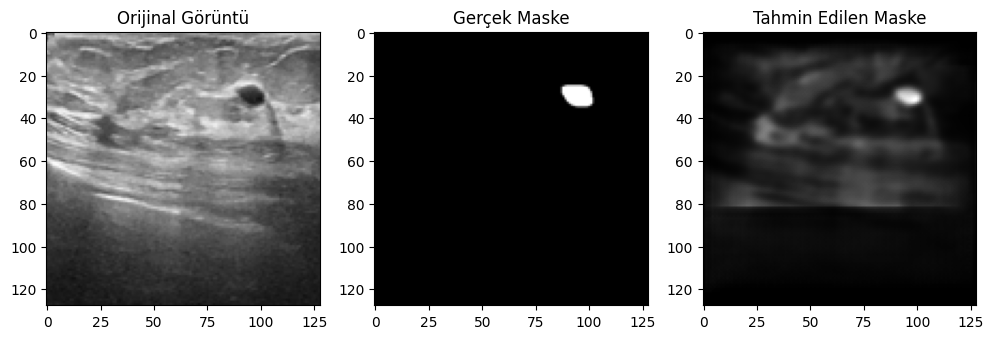

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


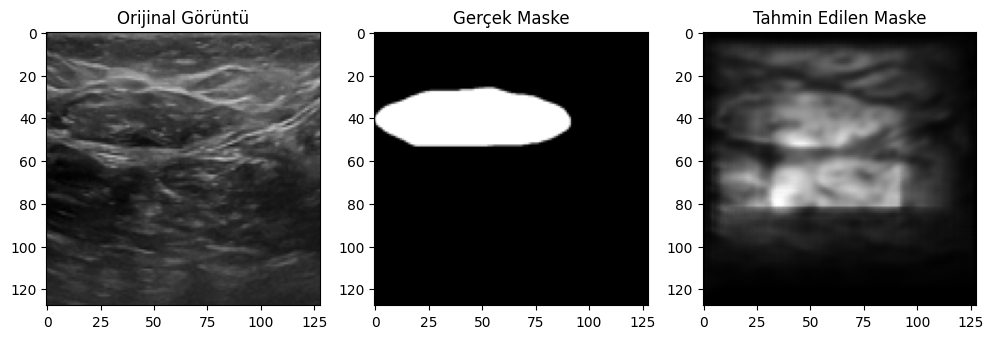

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


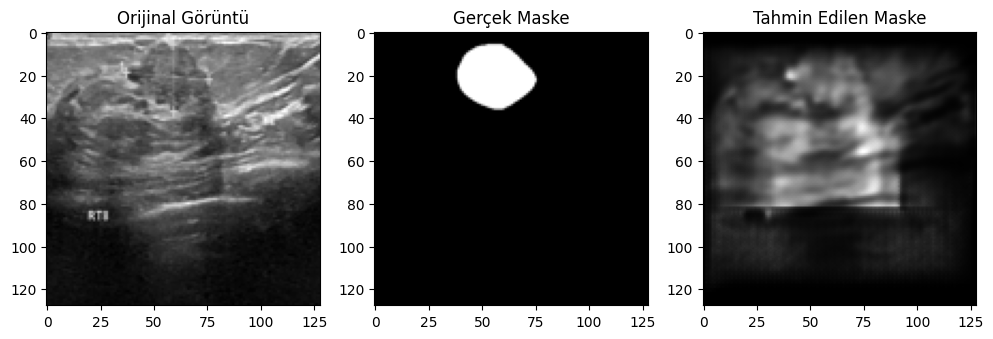

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


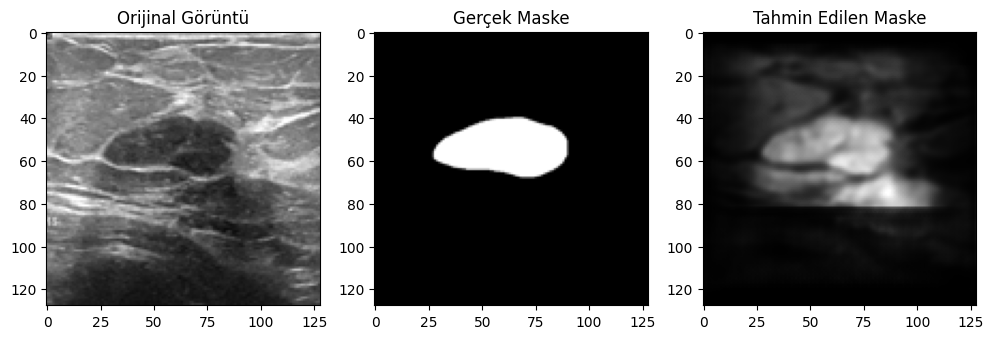

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


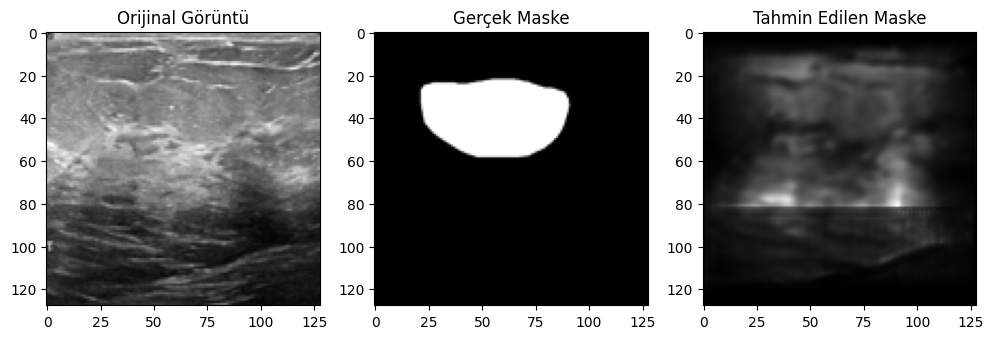

In [53]:
# İlk 5 test örneği üzerinde tahminleri inceleme
for i in range(5):
    sample_img = X_test[i]
    sample_mask = y_test[i]
    predicted_mask = model.predict(np.expand_dims(sample_img, axis=0))[0]

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Orijinal Görüntü")
    plt.imshow(sample_img)

    plt.subplot(1, 3, 2)
    plt.title("Gerçek Maske")
    plt.imshow(sample_mask.squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Tahmin Edilen Maske")
    plt.imshow(predicted_mask.squeeze(), cmap='gray')

    plt.show()


In [54]:
def binary_accuracy(true_mask, predicted_mask, threshold=0.5):
    predicted_mask = (predicted_mask > threshold).astype(np.float32)
    correct = np.sum(true_mask == predicted_mask)
    total = true_mask.size
    return correct / total

# Test setindeki tüm örnekler için binary accuracy hesaplama
binary_accuracies = []
for i in range(len(X_test)):
    true_mask = y_test[i].squeeze()
    predicted_mask = model.predict(np.expand_dims(X_test[i], axis=0))[0].squeeze()
    binary_accuracies.append(binary_accuracy(true_mask, predicted_mask))

# Ortalama Binary Accuracy
mean_binary_accuracy = np.mean(binary_accuracies)
print(f"Ortalama Binary Accuracy: {mean_binary_accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━